# Importing Libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

# Fetching Dataset

In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip

--2022-01-21 17:25:05--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.147
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.97.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3745528792 (3.5G) [application/octet-stream]
Saving to: ‘9xkhgts2s6-1.zip’

9xkhgts2s6-1.zip    100%[===================>]   3.49G  21.7MB/s    in 2m 46s  

2022-01-21 17:27:52 (21.5 MB/s) - ‘9xkhgts2s6-1.zip’ saved [3745528792/3745528792]



# Unzipping Dataset

In [3]:
%%capture
!unzip 9xkhgts2s6-1.zip

# Setting Directories and Hyperparameters

In [4]:
image_directory='Curated X-Ray Dataset/Curated X-Ray Dataset/'

no_covid_images=os.listdir(image_directory+ 'Normal/')
yes_covid_images=os.listdir(image_directory+ 'COVID-19/')
pneumonia_viral_images=os.listdir(image_directory+ 'Pneumonia-Viral/')

dataset=[]
label=[]

INPUT_SIZE=128

# Processing Dataset

In [5]:
for i , image_name in tqdm(enumerate(no_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Normal/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in tqdm(enumerate(yes_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'COVID-19/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

for i , image_name in tqdm(enumerate(pneumonia_viral_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Pneumonia-Viral/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(2)

3270it [01:51, 29.25it/s]
1281it [00:52, 24.58it/s]
1656it [00:36, 45.89it/s]


In [6]:
dataset=np.array(dataset)
label=np.array(label)

# Splitting Training and Validation Data

In [7]:
x_train, x_split, y_train, y_split = train_test_split(dataset, label, test_size=0.2, random_state=0)

x_train=tf.keras.utils.normalize(x_train, axis=1)
y_train=tf.keras.utils.to_categorical(y_train , num_classes=3)

# Splitting Validation and Testing Data

In [8]:
x_val, x_test, y_val, y_test = train_test_split(x_split, y_split, test_size=0.5, random_state=0)

x_val = tf.keras.utils.normalize(x_val, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

y_val = tf.keras.utils.to_categorical(y_val , num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=3)

# Setting Base Model

In [9]:
base_model_inceptionV3 = InceptionV3(input_shape=(128, 128, 3), weights='imagenet', include_top=False, pooling='max')

for layer in base_model_inceptionV3.layers:
    layer.trainable = False

2022-01-21 17:32:14.447885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 17:32:14.568993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 17:32:14.569727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 17:32:14.571499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


# Building Model Architecture

In [10]:
input = base_model_inceptionV3.input

x = base_model_inceptionV3.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(3, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# Plotting Function

In [11]:
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()

# Model Summary

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Compiling Model

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Training

In [14]:
%%time
history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    verbose=1, epochs=1000, 
    validation_data=(x_val, y_val)
    )

2022-01-21 17:32:32.136156: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.
2022-01-21 17:32:33.197258: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.
2022-01-21 17:32:33.945744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2022-01-21 17:32:38.443740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


156/156 [==============================] - 17s 46ms/step - loss: 0.9509 - accuracy: 0.8481 - val_loss: 0.3517 - val_accuracy: 0.8712
Epoch 2/1000
156/156 [==============================] - 5s 32ms/step - loss: 0.2609 - accuracy: 0.9053 - val_loss: 0.2614 - val_accuracy: 0.9098
Epoch 3/1000
156/156 [==============================] - 5s 32ms/step - loss: 0.2460 - accuracy: 0.9074 - val_loss: 0.2598 - val_accuracy: 0.9130
Epoch 4/1000
156/156 [==============================] - 5s 33ms/step - loss: 0.2169 - accuracy: 0.9217 - val_loss: 0.2877 - val_accuracy: 0.9114
Epoch 5/1000
156/156 [==============================] - 5s 32ms/step - loss: 0.1938 - accuracy: 0.9279 - val_loss: 0.2433 - val_accuracy: 0.9291
Epoch 6/1000
156/156 [==============================] - 5s 32ms/step - loss: 0.1914 - accuracy: 0.9347 - val_loss: 0.2536 - val_accuracy: 0.9098
Epoch 7/1000
156/156 [==============================] - 5s 33ms/step - loss: 0.1849 - accuracy: 0.9337 - val_loss: 0.2262 - val_accuracy: 0.92

# Saving Model

In [15]:
model.save(os.path.join("models", "model.final.h5"))

# Evaluating Model

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

20/20 [==============================] - 1s 28ms/step - loss: 0.8063 - accuracy: 0.9630
Test loss:  0.8063302040100098
Accuracy:  0.9629629850387573


# Saving History

In [17]:
history.history

{'loss': [0.9508838057518005,
  0.26085564494132996,
  0.24604174494743347,
  0.21688371896743774,
  0.19375815987586975,
  0.19136177003383636,
  0.1849006861448288,
  0.17702999711036682,
  0.165771022439003,
  0.1584198921918869,
  0.15197408199310303,
  0.1433739811182022,
  0.14788010716438293,
  0.1304156631231308,
  0.14593861997127533,
  0.13546770811080933,
  0.13051190972328186,
  0.1424473375082016,
  0.11873509734869003,
  0.14480605721473694,
  0.1417844444513321,
  0.13451765477657318,
  0.12363515794277191,
  0.11848090589046478,
  0.1069120541214943,
  0.1090238094329834,
  0.11736135184764862,
  0.11055073142051697,
  0.11050248146057129,
  0.10422708839178085,
  0.10848326981067657,
  0.10133732110261917,
  0.09021145105361938,
  0.08781929314136505,
  0.08005676418542862,
  0.07651916146278381,
  0.08607328683137894,
  0.08505487442016602,
  0.08797671645879745,
  0.08645979315042496,
  0.07747118920087814,
  0.08602889627218246,
  0.0787147581577301,
  0.08645536750

# Plotting Curves

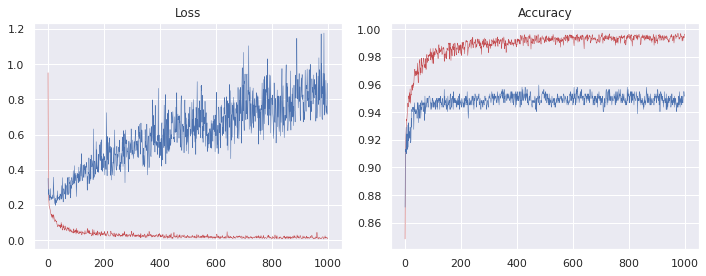

In [18]:
plot(history.history)

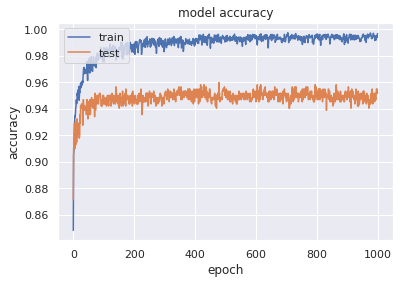

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

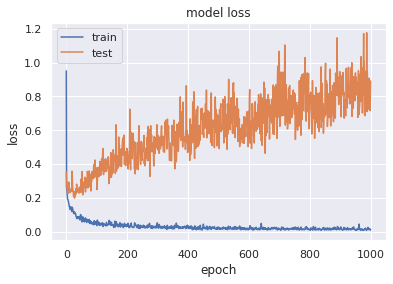

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
%%time
model.predict(x_train)

2022-01-21 19:05:12.843385: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.
2022-01-21 19:05:13.903511: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 976158720 exceeds 10% of free system memory.


CPU times: user 5.66 s, sys: 2.13 s, total: 7.79 s
Wall time: 7.44 s


array([[1.0000000e+00, 0.0000000e+00, 7.6026169e-29],
       [8.7945484e-10, 2.5657429e-10, 1.0000000e+00],
       [1.0000000e+00, 1.5501504e-20, 2.2534390e-16],
       ...,
       [9.9998307e-01, 1.6049743e-09, 1.6917560e-05],
       [1.0000000e+00, 7.0057164e-25, 1.6046391e-18],
       [1.0000000e+00, 1.2575795e-19, 1.1164454e-14]], dtype=float32)

In [22]:
%%time
y_pred = model.predict(x_test)

CPU times: user 626 ms, sys: 180 ms, total: 806 ms
Wall time: 920 ms


In [23]:
Y_pred = np.argmax(y_pred, axis=1)

In [24]:
Y_test = np.argmax(y_test, axis=1)

In [25]:
Y_test  

array([0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0,
       2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1,
       0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       2, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0,
       2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0,
       0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0,

In [26]:
Y_pred

array([0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0,
       2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1,
       0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0,
       0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       2, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0,
       2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0,

In [27]:
%%time
result = model.predict(x_test[[0]])

CPU times: user 262 ms, sys: 1.76 ms, total: 264 ms
Wall time: 273 ms


In [28]:
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[325   1   4]
 [  3 118   2]
 [ 10   3 155]]
Accuracy :  0.7133655394524959
Sensitivity :  0.9969325153374233
Specificity :  0.9752066115702479


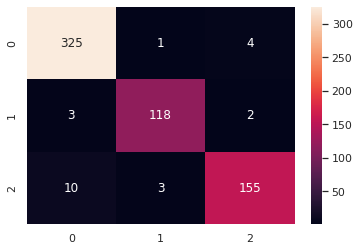

In [29]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

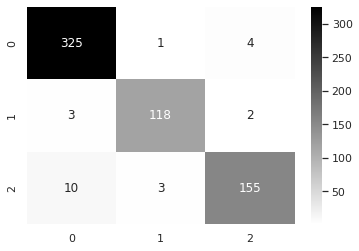

In [30]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="binary",annot=True,fmt="d")

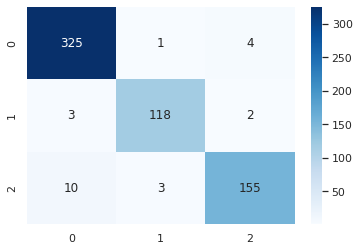

In [31]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="Blues", annot=True,fmt="d")

In [32]:
print(classification_report(Y_test, Y_pred, target_names = ['NORMAL', 'COVID', 'Pneumonia']))

              precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       330
       COVID       0.97      0.96      0.96       123
   Pneumonia       0.96      0.92      0.94       168

    accuracy                           0.96       621
   macro avg       0.96      0.96      0.96       621
weighted avg       0.96      0.96      0.96       621



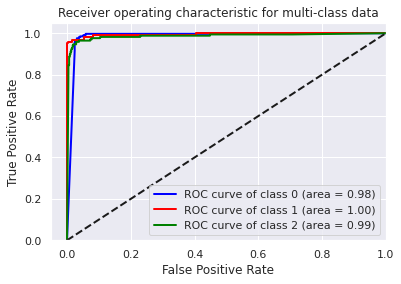

In [33]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [34]:
def display_training_curves(history, name, model_name, EPOCHS =1000):
    '''
    Plots the training process
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,15))
    fig.suptitle(model_name, size=20)
    
    # plot AUC
    ax1.plot(np.arange(EPOCHS),history.history['accuracy'],'-o',
             label='train',color='#ff7f0e')
    ax1.plot(np.arange(EPOCHS),history.history['val_accuracy'],'-o',
             label='val',color='#1f77b4')
    x = np.argmax(history.history['val_accuracy']); y = np.max(history.history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    ax1.scatter(x,y,s=200,color='#1f77b4')
    ax1.text(x-0.03*xdist,y-0.05*ydist,'max accuracy\n%.2f'%y,size=14)
    ax1.set_ylabel('Accuracy',size=14); ax1.set_xlabel('Epoch',size=14)
    ax1.set_title('Accuracy')
    ax1.set_xticks(list(range(EPOCHS)))
    ax1.set_xticklabels(list(range(1, EPOCHS+1)))
    ax1.legend(loc=2)

    #  plot loss
    ax2.plot(np.arange(EPOCHS),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    ax2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin(history.history['val_loss'] )
    y = np.min(history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    ax2.scatter(x,y,s=200,color='#d62728')
    ax2.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    ax2.set_ylabel('Loss',size=14); ax2.set_xlabel('Epoch',size=14)
    ax2.set_title('Loss')
    ax2.set_xticks(list(range(EPOCHS)))
    ax2.set_xticklabels(list(range(1, EPOCHS+1)))
    ax2.legend(loc=3)
    plt.savefig(name + '.png')
    plt.show() 

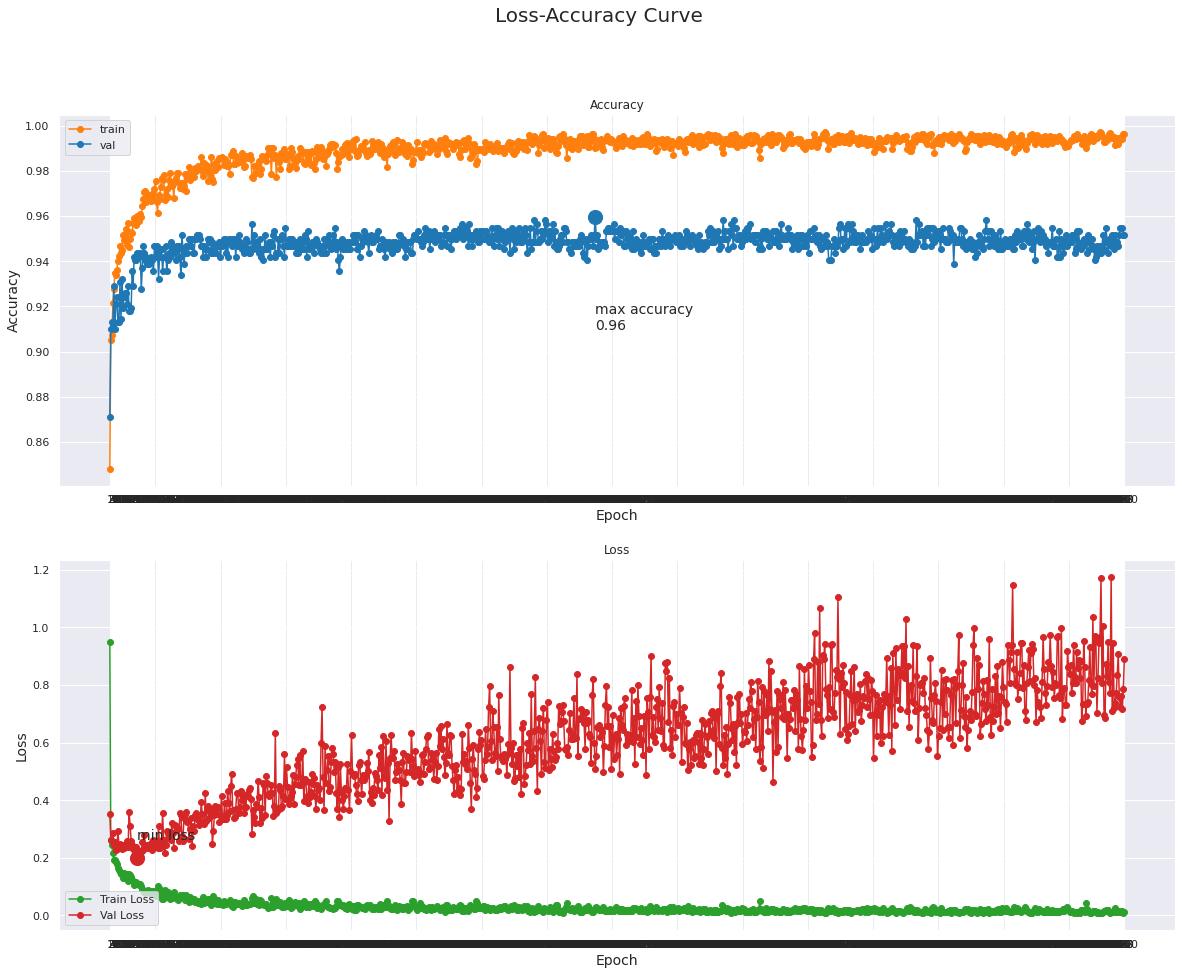

In [35]:
display_training_curves(history, 'name', 'Loss-Accuracy Curve')